In [1]:
import numpy as np
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

# Load #

In [2]:
data = np.load('data/landfill_clear_plastic.npz')
landfill = data['arr_0']
background = data['arr_1']
spectrum = data['arr_2']
spectrum[np.isnan(spectrum)] = 0

# Whitening Matrix #

In [3]:
def whitening_matrix(m):
    old_shape = m.shape
    m = m.reshape(-1, old_shape[-1])
    mean = np.mean(m, axis=0)
    cov = np.cov(m - mean, rowvar=False)
    w, v = np.linalg.eig(cov)
    W = np.matmul(np.matmul(v, np.diag(1 / np.sqrt(1e-6 + w))), v.T)
    return W, mean

# Training Data #

In [4]:
W, mean = whitening_matrix(background)

In [5]:
(x, y, c) = background.shape
centered_background_pixels = (background-mean).reshape(-1, c)
centered_landfill_pixels = (landfill-mean).reshape(-1, c)
centered_plastic_pixels = np.tile(spectrum-mean, (x*y, 1))
centered_spectrum = (spectrum-mean).reshape(-1, 1)

In [6]:
fg = np.matmul(np.matmul(centered_landfill_pixels, W), centered_spectrum).reshape(x, y, -1)
bg = np.matmul(np.matmul(centered_background_pixels, W), centered_spectrum).reshape(x, y, -1)
pl = np.matmul(np.matmul(centered_plastic_pixels, W), centered_spectrum).reshape(x, y, -1)

-746.1797236283862 111.9984771359624


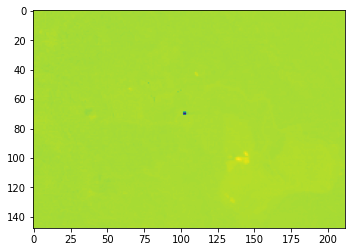

In [7]:
plt.imshow(fg)
print(np.min(fg), np.max(fg))

-52.76266587327678 80.50847623533636


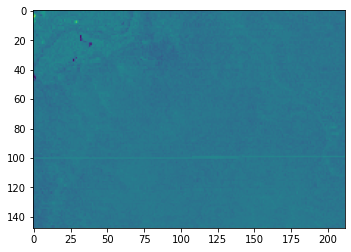

In [8]:
plt.imshow(bg)
print(np.min(bg), np.max(bg))

262.63860632715796 262.6386063271581


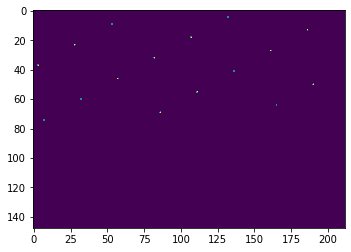

In [9]:
plt.imshow(pl)
print(np.min(pl), np.max(pl))

In [10]:
lo = min(np.min(bg), np.min(pl))
hi = max(np.max(bg), np.max(pl))

In [11]:
scale = 1/(hi - lo)
bias = -lo * scale

In [ ]:
plt.imshow(fg * scale + bias)

In [ ]:
plt.imshow(bg * scale + bias)

In [ ]:
plt.imshow(pl * scale + bias)

# PyTorch Module #

In [12]:
device = torch.device("cuda")
# device = torch.device("cpu")

In [13]:
class Whiten(torch.nn.Module):
    
    def __init__(self, W, bias):
        super(Whiten, self).__init__()

        _W = torch.from_numpy(W.astype(np.float)).unsqueeze(2)
        _W = torch.nn.parameter.Parameter(_W)
        self.register_parameter('W', _W)

        _bias = torch.from_numpy(np.array(bias).astype(np.float)).reshape(1)
        _bias = torch.nn.parameter.Parameter(_bias)
        self.register_parameter('bias', _bias)

        self.relu = torch.nn.ReLU()

    def forward(self, x, y):
        x = F.conv1d(x, self.W)
        y = F.conv1d(y, self.W)
        x = F.conv1d(x, y, self.bias)
        x = self.relu(x)
        return x


## Use Module ##

Will start from the PCA-derived decorrelation matrix.

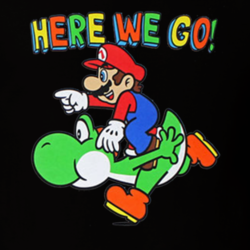

In [14]:
ps = np.concatenate([centered_background_pixels, centered_plastic_pixels], 0)
ps = torch.from_numpy(ps.astype(np.float)).unsqueeze(2).to(device)

ps2 = torch.from_numpy(centered_landfill_pixels.astype(np.float)).unsqueeze(2).to(device)

ls = np.concatenate([np.zeros((x*y, 1)), np.ones((x*y, 1))])
ls = torch.from_numpy(ls.astype(np.float)).unsqueeze(2).to(device)

v = torch.from_numpy(centered_spectrum.astype(np.float)).unsqueeze(0).to(device)

In [15]:
model = Whiten(W*scale, bias).to(device)

[0.16728742]


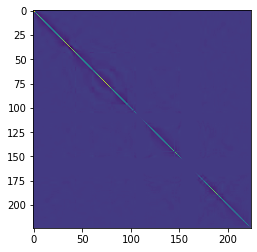

In [16]:
before = model.W.cpu().detach().numpy()
print(model.bias.cpu().detach().numpy())
plt.imshow(before)

0.12413181673910333 0.29256366013417956


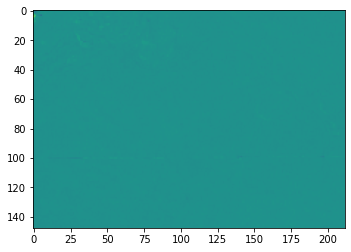

In [17]:
blah = model(ps, v).cpu().detach().numpy()
blah = blah.reshape(x*2, y, 1)[:x, :, :]
plt.imshow(blah, vmin=0.0, vmax=0.33)
print(np.min(blah), np.max(blah))

0.0 0.3221330748895815


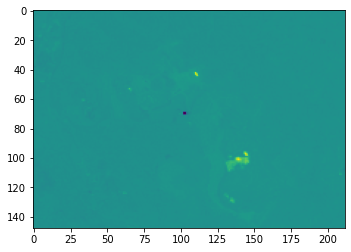

In [18]:
blah = model(ps2, v).cpu().detach().numpy().reshape((x, y, 1))
plt.imshow(blah, vmin=0.0, vmax=0.33)
print(np.min(blah), np.max(blah))

In [19]:
for parameter in model.parameters():
    parameter.requires_grad = True

obj = torch.nn.BCEWithLogitsLoss().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [20]:
for i in range(0,500):
    opt.zero_grad()
    pred = model(ps, v)
    loss = obj(pred, ls)
    loss.backward()
    opt.step()

[0.07377203]


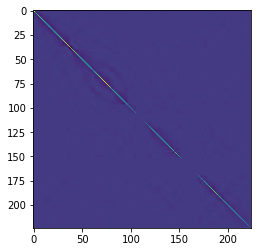

In [21]:
after = model.W.cpu().detach().numpy()
print(model.bias.cpu().detach().numpy())
plt.imshow(after)

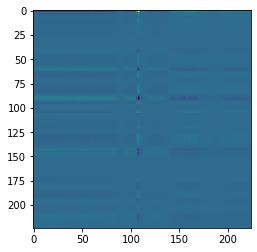

In [22]:
plt.imshow(before-after)

In [23]:
blah1 = model(ps, v).cpu().detach().numpy().reshape(x*2, y, 1)[:x, :, :]
blah2 = model(ps2, v).cpu().detach().numpy().reshape(x, y, 1)

In [24]:
print(np.min(blah1), np.max(blah1))
print(np.min(blah2), np.max(blah2))

0.0 0.7138942816634865
0.0 1.0804438280882422


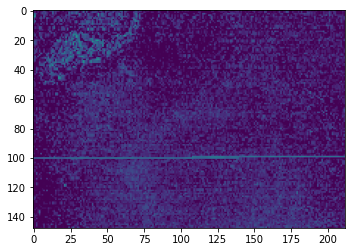

In [25]:
plt.imshow(blah1, vmin=0.0, vmax=1.09)

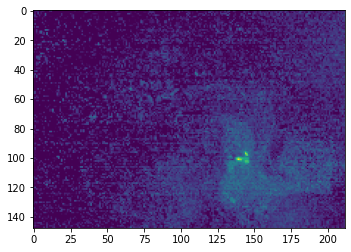

In [26]:
plt.imshow(blah2, vmin=0.0, vmax=1.09)

## Starting from Identity ##

In [ ]:
W2 = np.eye(224).astype(np.float) * 1.0e-2
bias2 = np.float(0.0)

In [ ]:
model2 = Whiten(W2, bias2).to(device)

In [ ]:
for parameter in model2.parameters():
    parameter.requires_grad = True

obj = torch.nn.BCEWithLogitsLoss().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-1)

In [ ]:
for i in range(0, 33):
    opt.zero_grad()
    pred = model2(ps, v)
    loss = obj(pred, ls)
    loss.backward()
    opt.step()

In [ ]:
print(model2.bias.cpu().detach().numpy())
plt.imshow(model2.W.cpu().detach().numpy())

In [ ]:
blah3 = model2(ps, v).cpu().detach().numpy().reshape(x*2, y, 1)[:x, :, :]
blah4 = model2(ps2, v).cpu().detach().numpy().reshape(x, y, 1)

In [ ]:
plt.imshow(blah3)
print(np.min(blah3), np.max(blah3))

In [ ]:
plt.imshow(blah4)
print(np.min(blah4), np.max(blah4))

# Saliency #

In [27]:
model.eval()
ps.requires_grad_()
pass

In [28]:
pred = model(ps, v)

In [29]:
plastic_pixel = pred[60000, :, :]

In [30]:
plastic_pixel.backward()

In [31]:
saliency = ps.grad.data.cpu().detach().numpy()

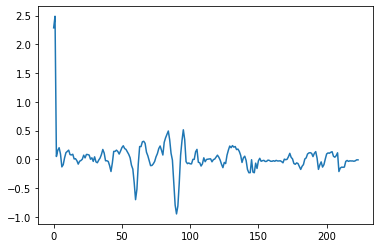

In [32]:
plt.plot(saliency[60000, :, :])

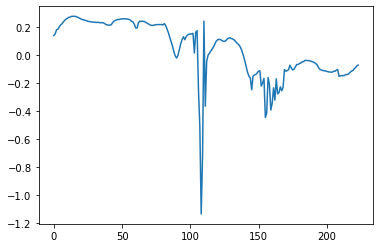

In [33]:
plt.plot(centered_spectrum)

In [34]:
according_to_saliency = np.argsort(np.abs(saliency[60000, :, :]), axis=0)

In [35]:
according_to_spectrum = np.argsort(np.abs(centered_spectrum), axis=0)

In [ ]:
diffs = []
for k in range(len(according_to_saliency)):
    i = according_to_saliency[k]
    j = int(np.where(according_to_spectrum == i)[0])
    diffs.append(k-j)

In [ ]:
according_to_saliency[:50]

In [ ]:
according_to_saliency[-50:]

# 50 Bands #

## 50 "Best" Bands ##

In [ ]:
background50 = background[:, :, according_to_saliency[-50:]].squeeze()
landfill50 = landfill[:, :, according_to_saliency[-50:]].squeeze()
spectrum50 = spectrum[according_to_saliency[-50:]].squeeze()

## 50 "Best" Bands ex Outliers ##

In [36]:
background50 = background[:, :, according_to_saliency[-52:-2]].squeeze()
landfill50 = landfill[:, :, according_to_saliency[-52:-2]].squeeze()
spectrum50 = spectrum[according_to_saliency[-52:-2]].squeeze()

## 50 "Worst" Bands ##

In [ ]:
background50 = background[:, :, according_to_saliency[:50]].squeeze()
landfill50 = landfill[:, :, according_to_saliency[:50]].squeeze()
spectrum50 = spectrum[according_to_saliency[:50]].squeeze()

## Compute ##

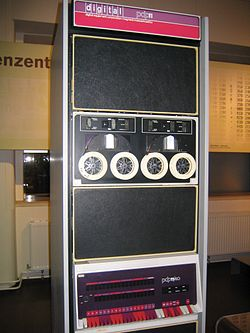

In [37]:
W50, mean50 = whitening_matrix(background50)

In [38]:
centered_background_pixels50 = (background50-mean50).reshape(-1, 50)
centered_landfill_pixels50 = (landfill50-mean50).reshape(-1, 50)
centered_plastic_pixels50 = np.tile(spectrum50-mean50, (x*y, 1))
centered_spectrum50 = (spectrum50-mean50).reshape(-1, 1)

In [39]:
fg50 = np.matmul(np.matmul(centered_landfill_pixels50, W50), centered_spectrum50).reshape(x, y, -1)
bg50 = np.matmul(np.matmul(centered_background_pixels50, W50), centered_spectrum50).reshape(x, y, -1)
pl50 = np.matmul(np.matmul(centered_plastic_pixels50, W50), centered_spectrum50).reshape(x, y, -1)

In [40]:
print(np.min(bg50), np.max(bg50))
print(np.min(fg50), np.max(fg50))

-10.603783269424424 37.67641169911497
-123.28425443549196 52.447396746182044


In [41]:
lo50 = min(np.min(bg50), np.min(pl50))
hi50 = max(np.max(bg50), np.max(pl50))
scale50 = 1/(hi50 - lo50)
bias50 = -lo50 * scale50

In [42]:
ps50 = np.concatenate([centered_background_pixels50, centered_plastic_pixels50], 0)
ps50 = torch.from_numpy(ps50.astype(np.float)).unsqueeze(2).to(device)

ps2_50 = torch.from_numpy(centered_landfill_pixels50.astype(np.float)).unsqueeze(2).to(device)

ls50 = np.concatenate([np.zeros((x*y, 1)), np.ones((x*y, 1))])
ls50 = torch.from_numpy(ls50.astype(np.float)).unsqueeze(2).to(device)

v50 = torch.from_numpy(centered_spectrum50.astype(np.float)).unsqueeze(0).to(device)

In [43]:
model50 = Whiten(W50*scale50, bias50).to(device)

0.0 0.729303471103835


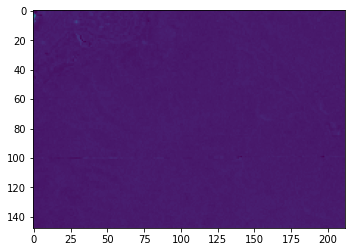

In [44]:
blah = model50(ps50, v50).cpu().detach().numpy()
blah = blah.reshape(x*2, y, 1)[:x, :, :]
plt.imshow(blah, vmin=0.0, vmax=1.15)
print(np.min(blah), np.max(blah))

0.0 0.9372782995069199


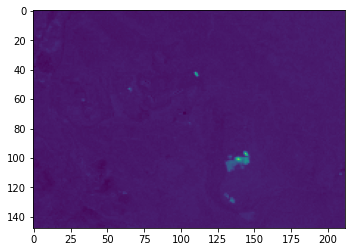

In [45]:
blah = model50(ps2_50, v50).cpu().detach().numpy().reshape((x, y, 1))
plt.imshow(blah, vmin=0.0, vmax=1.15)
print(np.min(blah), np.max(blah))

In [46]:
for parameter in model50.parameters():
    parameter.requires_grad = True

obj50 = torch.nn.BCEWithLogitsLoss().to(device)
opt50 = torch.optim.SGD(model50.parameters(), lr=1e-4, momentum=0.9)

In [47]:
for i in range(0,500):
    opt50.zero_grad()
    pred = model50(ps50, v50)
    loss = obj50(pred, ls50)
    loss.backward()
    opt50.step()

In [48]:
blah1 = model50(ps50, v50).cpu().detach().numpy().reshape(x*2, y, 1)[:x, :, :]
blah2 = model50(ps2_50, v50).cpu().detach().numpy().reshape(x, y, 1)
print(np.min(blah1), np.max(blah1))
print(np.min(blah2), np.max(blah2))

0.0 0.7207352765475175
0.0 0.9769494083267595


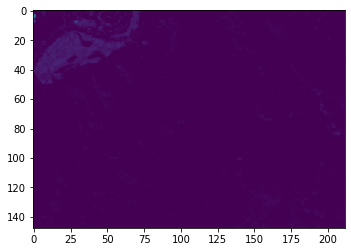

In [49]:
plt.imshow(blah1, vmin=0.0, vmax=np.max(blah2))

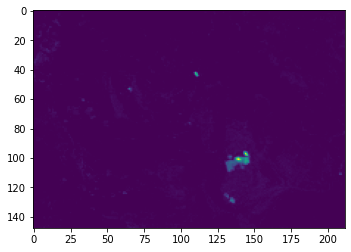

In [50]:
plt.imshow(blah2, vmin=0.0, vmax=np.max(blah2))